# Transfer learning - densenet201 on CIFAR-10 - break after epoch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import adabound # https://github.com/Luolc/AdaBound
from torchsummary import summary
import json

from torch.utils.tensorboard import SummaryWriter

# For notificaiton
#import AppKit

Device chosen GPU: NVIDIA TITAN RTX
Files already downloaded and verified
Files already downloaded and verified


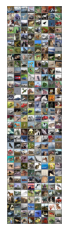

In [2]:
device = torch.device("cuda:0")
print("Device chosen GPU:", torch.cuda.get_device_name(device))

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 35
batch_size = 256
learning_rate = 0.0001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/CIFAR10/densenet201/v1.1.3 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer1  = SummaryWriter(log_directory)
#writer2 = SummaryWriter(log_directory)

# Loading dataset
# Since the dataset is in PIL (Python Imaging Library) form, tranform them into tensors of normalised range [-1, 1]
transform = transforms.Compose( # this transforms.compose combines multiple tranformations as one
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

# The CIFAR10 tataset is avaliable in PyTorch
train_dataset = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=True,  download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./cifar10Dataset', train=False, download=True, transform=transform)

# Splitting the training and testing datasets into smaller batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Checking a data sample 
example = iter(test_loader)
images, labels = example.next()

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [3]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading a model
model = torchvision.models.densenet201(pretrained=True)
num_features = model.features     # Getting the number of features going into the fully connected layer

# Finetuning
for param in model.parameters():    # Freezing the startign layers
    # param.requires_grad = False
    param.requires_grad = True

model.fc = nn.Linear(len(num_features), 10)  # Redefining the layer with the same input features, but new output features (the amount of classes that we need to classify)
model.to(device)

#summary(model, (3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08) # Comment this if a model is loaded

n_total_steps = len(train_loader)


In [4]:
# Training

# Tensorboard
#writer1.add_graph(model, images)
#writer1.close()

# Doing the training now

running_loss = 0
running_correct = 0
#running_loss_test = 0

steps_until_print = batch_size
#print(f'One batch has {len(example)/batch_size} images\nPrint every {steps_until_print}')

model.train()
for epoch in range(num_epochs):
    # Check for stop - read file for boolean to stopping safely
    train_json = open("train.json")
    train_dict = json.load(train_json)
    if train_dict["train"] == "False": break
    
    testing_batches = iter(test_loader) # Every epoch tests the whole dataset once

    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights (these are the model parameters(), different from hyperparameters)

        with torch.no_grad():
            # Add loss to the running loss 
            running_loss = loss.item()
            _, predictions = torch.max(outputs, 1)                  # Evaluate along the 1st dimension

            running_correct = (predictions == labels).sum().item()  # We can call .item() as it's a tensor with one item

            if (i+1) % 1 == 0: # Maybe replace 1 with steps_until_print
                # Logging the loss
                writer1.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                # Adding the accuracy
                writer1.add_scalar('Accuracy/training', running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # If for every 5 batches, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_labels = testing_batches.next()
                
                test_images = test_images.to(device)
                test_labels = test_labels.to(device)

                test_outputs = model(test_images)

                _, test_predictions = torch.max(test_outputs, 1)
                test_running_correct = (test_predictions == test_labels).sum().item()
                writer1.add_scalar('Accuracy/testing', test_running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                test_loss = criterion(test_outputs, test_labels)
                test_running_loss = test_loss.item()
                writer1.add_scalar('Loss/testing', test_running_loss/len(test_labels), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

    #writer2.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps) # label of the scalar, actual loss mean, current global step
    print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
    #print(f'Finished epoch {epoch+1}/{num_epochs}')

print("Training is done")
#AppKit.NSBeep()

Epoch 1/35, step 196/196, loss = 0.66883
Epoch 2/35, step 196/196, loss = 0.56980
Epoch 3/35, step 196/196, loss = 0.53652
Epoch 4/35, step 196/196, loss = 0.06723
Epoch 5/35, step 196/196, loss = 0.10398
Epoch 6/35, step 196/196, loss = 0.06696
Epoch 7/35, step 196/196, loss = 0.10039
Epoch 8/35, step 196/196, loss = 0.21649
Epoch 9/35, step 196/196, loss = 0.22703
Training is done


In [13]:
# Saving the model
checkpoint = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimiser_state": optimiser.state_dict()
}
torch.save(checkpoint, "checkpoint_densenet201_84p_cifar10.pth")
# print(len(model.state_dict().keys()))
# keys = list(model.state_dict().keys())
# print(keys[0:10])
#print(optimiser.state_dict())

In [5]:
# Loading the saved model
model = torchvision.models.densenet201(pretrained=False)
num_features = model.features     # Getting the number of features going into the fully connected layer
model.fc = nn.Linear(len(num_features), 10)  # Redefining the layer with the same input features, but new output features (the amount of classes that we need to classify)
model.to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)

loaded_checkpoint = torch.load("checkpoint_densenet201_84p_cifar10.pth")
epoch = loaded_checkpoint["epoch"]
criterion = nn.CrossEntropyLoss()

# for param in model.parameters():    # Freezing the startign layers
#     # param.requires_grad = False
#     param.requires_grad = False

model.load_state_dict(loaded_checkpoint["model_state"])
optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])

## Testing model

In [11]:
# Detailed validation - accuracy for each class

model.eval() # Disables zeroed out neurons for better evaluation instead of training

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predictions = torch.max(outputs, 1)  # torch.max returns (value, index)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predictions[i]
            if(pred == label):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    accuracy = 100 * n_correct / n_samples
    print(f"General network accuracy = {accuracy}")

    for i in range(10):
        accuracy = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'{classes[i]} class accuracy: \t \t {accuracy}%')

model.train()

General network accuracy = 84.54
Plane class accuracy: 	 	 86.7%
Car class accuracy: 	 	 92.7%
Bird class accuracy: 	 	 83.1%
Cat class accuracy: 	 	 68.9%
Deer class accuracy: 	 	 85.8%
Dog class accuracy: 	 	 72.2%
Frog class accuracy: 	 	 89.8%
Horse class accuracy: 	 	 85.4%
Ship class accuracy: 	 	 92.3%
Truck class accuracy: 	 	 88.5%


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Breaking after epoch POC

In [29]:
# Stop training after epoch POC
import json
import time
keep_training = True
while(keep_training):
    # Opening json 
    train_json = open("train.json")
    train_dict = json.load(train_json)
    # Interpret "train" value as boolean
    keep_training = False if train_dict["train"] == "False" else True
    time.sleep(1)

In [ ]:
# Implementation of previous line
import json

keep_training = True
while(keep_training):
    # Opening json 
    train_json = open("train.json")
    train_dict = json.load(train_json)
    # Interpret "train" value as boolean
    keep_training = False if train_dict["train"] == "False" else True

In [27]:
# Final implementation
import json
import time
keep_training = True
for a in range(0, 120):
    # Opening json 
    train_json = open("train.json")
    train_dict = json.load(train_json)
    if train_dict["train"] == "False": break
    time.sleep(1)